In [26]:
import matplotlib

matplotlib.rc('font', size=11, family='serif')
matplotlib.rc('text', usetex=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb

from matplotlib import cm
from matplotlib.colors import Normalize

import matplotlib.transforms as mtransforms



$$
    \sigma_\epsilon^2 = - \sigma_x^2 \cdot \beta^2 + \sigma_y^2
$$

$$
    \hat{\sigma}_\epsilon^2 = \frac{\sigma_y^2\sigma_\eta^2 + \sigma_\epsilon^2\sigma_x^2}{\sigma_\eta^2 + \sigma_x^2}
$$

$$
    \hat{\sigma}_\epsilon^2 = \frac{\sigma_\eta^2 + \sigma_\epsilon^2}{\sigma_\eta^2 + 1}
$$

In [3]:
def theoretic_sigma(sample_size, effect_size, sigma_p, sigma_x, sigma_r, alpha):
  return effect_size**2 * sigma_p**2 * sigma_x**2 / (sigma_p**2 + sigma_x**2) + sigma_r**2

def theoretic_loglik(sample_size, effect_size, sigma_p, sigma_x, sigma_r, alpha):
  return -sample_size / 2 * np.log(2 * np.pi * theoretic_sigma(sample_size, effect_size, sigma_p, sigma_x, sigma_r, alpha)) - sample_size / 2

def theoretic_aic(sample_size, effect_size, sigma_p, sigma_x, sigma_r, alpha, k=3):
  return 2 * k - 2 * theoretic_loglik(sample_size, effect_size, sigma_p, sigma_x, sigma_r, alpha)



In [4]:
def ols(x, y): 
    beta = np.sum((x - np.mean(x)) * (y - np.mean(y))) / np.sum((x - np.mean(x))**2)
    alpha = np.mean(y) - beta * np.mean(x)
    sigma = np.sqrt(np.sum((y - alpha - beta * x)**2)/(len(x)))
    aic = -2 * (-len(x) / 2 * np.log(2 * np.pi * sigma**2) - len(x) / 2) + 2 * 3

    return alpha, beta, sigma, aic

In [5]:

def run_simulations(y, sigma_eta, n_repeats = 1000, x_random=0, max_error = 10):
    betas1 = np.zeros(n_repeats)
    scales1 = np.zeros(n_repeats)
    aics1 = np.zeros(n_repeats)
    x_vars = np.zeros(n_repeats)
    aics2 = np.zeros(n_repeats)
    scales2 = np.zeros(n_repeats)
    sample_size = y.shape[0]
    
    for i, add_error in enumerate(np.linspace(0.001, max_error, n_repeats)):
        x_w_var = np.random.normal(0, add_error, sample_size)
        x = x_random * y + x_w_var
        x_vars[i] = np.std(x)

        alpha, beta, sigma, aic = ols(x, y)
        betas1[i] = beta
        scales1[i] = sigma
        aics1[i] = aic

        x_err = np.random.normal(0, 1, sample_size) 
        x_err = x_err / np.std(x_err) * sigma_eta
        x = x + x_err
        alpha, beta, sigma, aic = ols(x, y)

        aics2[i] = aic
        scales2[i] = sigma

    return x_vars, betas1, scales1, aics1, aics2, scales2

In [6]:
n_repeats = 10000

sample_size = 100
y_var = 2
sigma_etas = [0, 0.5, 1]
betas = np.zeros((len(sigma_etas), n_repeats * 3))
scales = np.zeros((len(sigma_etas), n_repeats * 3))
x_vars = np.zeros((len(sigma_etas), n_repeats * 3))
aics1 = np.zeros((len(sigma_etas), n_repeats * 3))
aics2 = np.zeros((len(sigma_etas), n_repeats * 3))
scales2 = np.zeros((len(sigma_etas), n_repeats * 3))


for i, sigma_eta in enumerate(sigma_etas): 
    y = np.random.normal(0, 2, sample_size)
    y = (y - np.mean(y)) / np.std(y) * y_var

    x_vars[i,:n_repeats], betas[i,:n_repeats], scales[i,:n_repeats], aics1[i,:n_repeats], aics2[i,:n_repeats], scales2[i, :n_repeats] = run_simulations(y, sigma_eta, n_repeats=n_repeats, x_random=0)
    x_vars[i,n_repeats:2*n_repeats], betas[i,n_repeats:2*n_repeats], scales[i,n_repeats:2*n_repeats], aics1[i,n_repeats:2*n_repeats], aics2[i,n_repeats:2*n_repeats], scales2[i,n_repeats:2*n_repeats] = run_simulations(y, sigma_eta, n_repeats=n_repeats, x_random=1)
    x_vars[i,2*n_repeats:], betas[i,2*n_repeats:], scales[i,2*n_repeats:], aics1[i,2*n_repeats:], aics2[i,2*n_repeats:], scales2[i,2*n_repeats:] = run_simulations(y, sigma_eta, n_repeats=n_repeats, x_random=-1)

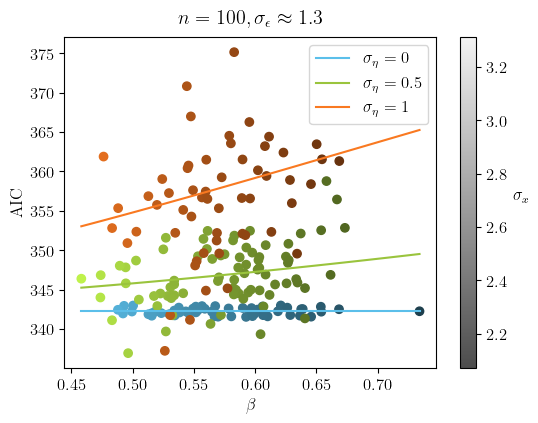

In [13]:


colors = ['#5BC0EB', '#FDE74C', '#9BC53D', '#E55934', '#FA7921']
# (253, 231, 76), (229, 89, 52), 
colors = np.array([(91, 192, 235), (155, 197, 61), (250, 121, 33)]) / 256

min_light = 0.2
max_light = 0.8

colors_hsv = rgb_to_hsv(colors)
min_colors = colors_hsv.copy()
min_colors[:,2] = 0.3
max_colors = colors_hsv.copy()
max_colors[:,2] = 0.95 

min_colors = hsv_to_rgb(min_colors)
max_colors = hsv_to_rgb(max_colors)

sigma_eps = 1.3
scales_fitting = (np.abs(scales - sigma_eps) < 0.005) & (betas > 0)

betas_for_func = np.linspace(np.min(betas[scales_fitting]), np.max(betas[scales_fitting]), 100)
dist = betas_for_func[1] - betas_for_func[0]

xvarmin = np.min(x_vars[scales_fitting])
xvarmax = np.max(x_vars[scales_fitting])

fig, ax = plt.subplots()

fig.set_size_inches(6, 4.3)

for j, x_err_var in enumerate(sigma_etas):
    scales_fitting = (np.abs(scales[j] - sigma_eps) < 0.005) & (betas[j] > 0)

    cmap = LinearSegmentedColormap.from_list(f'map{j}', [min_colors[j], max_colors[j]])

    scatter = ax.scatter(betas[j, scales_fitting], aics2[j, scales_fitting], c=x_vars[j, scales_fitting], cmap=cmap, vmin = xvarmin, vmax=xvarmax)

    avg_xvars = np.zeros(len(betas_for_func))

    for i, f_beta in enumerate(betas_for_func):
        avg_xvars[i] = np.sqrt((y_var**2 - sigma_eps**2) / f_beta**2)

    aics_theor = theoretic_aic(sample_size, betas_for_func, avg_xvars, x_err_var, sigma_eps, 0, k=3)

    ax.plot(betas_for_func, aics_theor, label=f'$\sigma_\eta = {x_err_var}$', color=colors[j])

cmap =  LinearSegmentedColormap.from_list(f'map_grey', [hsv_to_rgb(np.array([0, 0, 0.3])), hsv_to_rgb(np.array([0, 0, 0.95]))])
cbar = ax.figure.colorbar(cm.ScalarMappable(Normalize(xvarmin, xvarmax), cmap), ax=ax)
cbar.ax.set_ylabel('$\sigma_x$', rotation=0, va='bottom', labelpad=10)

ax.set_xlabel(r'$\beta$')

ax.set_ylabel('AIC')
ax.legend()
ax.set_title(f'$n = {sample_size}, \sigma_\epsilon ' + r'\approx' + f' {sigma_eps}$', pad=10)

fig.savefig('plots/aic_beta_sigma_x.pdf')

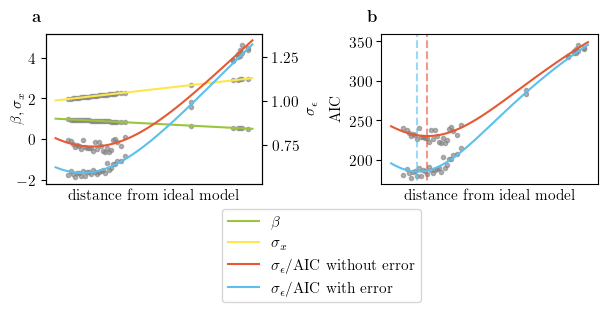

In [36]:

colors = ['#5BC0EB', '#9BC53D', '#E55934', '#FA7921', '#FDE74C']


x_var = np.linspace(1.9, 3, 100)
y_var = 2
effect_sizes = np.linspace(1, 0.5, 100)
model_error = np.sqrt(-effect_sizes**2 * x_var**2 + y_var**2)
x = np.arange(100)

fig, axes = plt.subplot_mosaic([['a', 'b'], ['legend', 'legend']], 
                               gridspec_kw = dict(height_ratios=[1, 0.4], width_ratios=[1, 1], 
                                                  wspace=0.55, hspace=0.4, 
                                                  left=0.07,right=.99,top=.9,bottom=0.06))
fig.set_size_inches(6, 3)

for label, ax1 in axes.items():
    # label physical distance to the left and up:
    if label == 'legend':
        continue
    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
    ax1.text(0, 1.0, r'\textbf{' + label + '}', transform=ax1.transAxes + trans,
            fontsize=12, weight='bold', va='bottom')








aics_true = np.zeros(len(x))
aics = np.zeros(len(x))
betas_true = np.zeros(len(x))
x_vars_true = np.zeros(len(x))


for i in x:
    fitting = (np.abs(betas[1] - effect_sizes[i]) < 0.005) & (np.abs(x_vars[1] - x_var[i]) < 0.005)

    if np.any(fitting):
        aics_true[i] = np.mean(scales[1, fitting])
        aics[i] = np.mean(scales2[1, fitting])
        betas_true[i] = np.mean(betas[1, fitting])
        x_vars_true[i] = np.mean(x_vars[1, fitting])

aics[aics == 0] = np.nan
aics_true[aics_true == 0] = np.nan  
x_vars_true[x_vars_true == 0] = np.nan
betas_true[betas_true == 0] = np.nan

ax2 = axes['a']
ax = ax2.twinx()

ax2.plot(x, betas_true, '.', color='grey', alpha=0.6)
ax2.plot(x, effect_sizes, color=colors[1])
ax2.set_ylabel(r'$\beta, \sigma_x$', labelpad=-5)
ax2.set_ylim(-2.2, 5.2)

ax2.plot(x, x_vars_true, '.', color='grey', alpha=0.6)
ax2.plot(x, x_var, color=colors[4])

ax2.set_xticks([])
ax2.set_xlabel('distance from ideal model')

"""
ax2 = ax2.twinx()
ax2.plot(x, x_vars_true, '.', color='grey', alpha=0.6)
ax2.plot(x, x_var, color=colors[4])
ax2.set_ylabel(r'$\sigma_x$', color=colors[4], labelpad=-5)
ax2.spines['left'].set_position(('outward', 35))
ax2.spines['left'].set_visible(True)
ax2.yaxis.set_label_position('left')
ax2.yaxis.set_ticks_position('left')
ax2.tick_params(axis='y', labelcolor=colors[4])
ax2.set_ylim(-2.2, 5.2)
"""



ax.plot(x, aics_true, '.', color='grey', alpha=0.6)
ax.plot(x, aics, '.', color='grey', alpha=0.6)

ax.plot(x, model_error, color=colors[0])

x_error = 0.5
model_errors2 = np.sqrt(theoretic_sigma(100, effect_sizes, x_var, x_error, model_error, y_var))
#aics = theoretic_aic(100, effect_sizes, x_var, x_error, np.sqrt(model_error), 0, k=1)


ax.plot(x, model_errors2, color=colors[2])


"""
ax.set_xticks([0, 50, 100], [1, 0.5, 0])
ax.set_xlabel(r'$\beta$')

ax2 = ax.twiny()
ax2.spines['bottom'].set_position(('outward', 40))
ax2.spines['bottom'].set_visible(True)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.set_ticks_position('bottom')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([0, 50, 100], [2, 3, 4])
ax2.set_xlabel(r'$\sigma_x$')

"""



ax.set_ylabel(r'$\sigma_\epsilon$')


ax = axes['b']
ax.set_xticks([])
ax.set_xlabel('distance from ideal model')



aics_true = np.zeros(len(x))
aics = np.zeros(len(x))

for i in x:
    fitting = (np.abs(betas[1] - effect_sizes[i]) < 0.005) & (np.abs(x_vars[1] - x_var[i]) < 0.005)

    if np.any(fitting):
        aics_true[i] = np.mean(aics1[1, fitting])
        aics[i] = np.mean(aics2[1, fitting])

aics[aics == 0] = np.nan
aics_true[aics_true == 0] = np.nan  

ax.plot(x, aics_true, '.', color='grey', alpha=0.6)
ax.plot(x, aics, '.', color='grey', alpha=0.6)

aics = theoretic_aic(100, effect_sizes, x_var, 0, model_error, 0, k=3)
ax.plot(x, aics, label='without x error', color=colors[0])

ax.vlines(np.argmin(aics), 0, 400, color=colors[0], alpha=0.6, linestyle='--')

aics = theoretic_aic(100, effect_sizes, x_var, x_error, model_error, 0, k=3)
ax.plot(x, aics, label='with x error', color=colors[2])

ax.set_ylabel('AIC')

ax.set_ylim(170, 360)

ax.vlines(np.argmin(aics), 0, 400, color=colors[2], alpha=0.6, linestyle='--')

"""
ax.set_xticks([0, 50, 100], [1, 0.5, 0])
ax.set_xlabel(r'$\beta$')

ax2 = ax.twiny()
ax2.spines['bottom'].set_position(('outward', 40))
ax2.spines['bottom'].set_visible(True)
ax2.xaxis.set_label_position('bottom')
ax2.xaxis.set_ticks_position('bottom')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks([0, 50, 100], [2, 3, 4])
ax2.set_xlabel(r'$\sigma_x$')
"""

ax = axes['legend']

ax.axis('off')
ax.plot([], [], color=colors[1], label=r'$\beta$')
ax.plot([], [], color=colors[4], label=r'$\sigma_x$')
ax.plot([], [], color=colors[2], label=r'$\sigma_\epsilon$/AIC without error')
ax.plot([], [], color=colors[0], label=r'$\sigma_\epsilon$/AIC with error')

ax.legend(loc='center')


fig.savefig('plots/edges_and_echos.pdf')

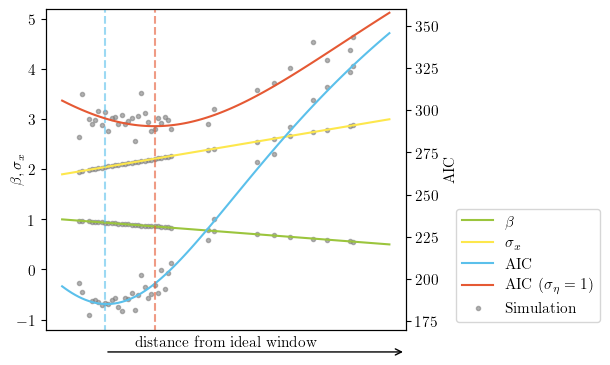

In [127]:
colors = ['#5BC0EB', '#9BC53D', '#E55934', '#FA7921', '#FDE74C']


x_var = np.linspace(1.9, 3, 100)
y_var = 2
effect_sizes = np.linspace(1, 0.5, 100)
x_error = 1
model_error = np.sqrt(-effect_sizes**2 * x_var**2 + y_var**2)
x = np.arange(100)

#fig, axes = plt.subplot_mosaic([['a', 'b'], ['legend', 'legend']], 
#                               gridspec_kw = dict(height_ratios=[1, 0.4], width_ratios=[1, 1], 
#                                                  wspace=0.55, hspace=0.4, 
#                                                  left=0.07,right=.99,top=.9,bottom=0.06))
fig, ax = plt.subplots(gridspec_kw=dict(left=0.07,right=.67,top=.99,bottom=0.1))

fig.set_size_inches(6, 3.6)

#for label, ax1 in axes.items():
#    # label physical distance to the left and up:
#    if label == 'legend':
#        continue
#    trans = mtransforms.ScaledTranslation(-10/72, 7/72, fig.dpi_scale_trans)
#    ax1.text(0, 1.0, r'\textbf{' + label + '}', transform=ax1.transAxes + trans,
#            fontsize=12, weight='bold', va='bottom')




aics_true = np.zeros(len(x))
aics = np.zeros(len(x))
betas_true = np.zeros(len(x))
x_vars_true = np.zeros(len(x))


for i in x:
    fitting = (np.abs(betas[2] - effect_sizes[i]) < 0.005) & (np.abs(x_vars[2] - x_var[i]) < 0.005)

    if np.any(fitting):
        aics_true[i] = np.mean(aics1[2, fitting])
        aics[i] = np.mean(aics2[2, fitting])
        betas_true[i] = np.mean(betas[2, fitting])
        x_vars_true[i] = np.mean(x_vars[2, fitting])

aics[aics == 0] = np.nan
aics_true[aics_true == 0] = np.nan  
x_vars_true[x_vars_true == 0] = np.nan
betas_true[betas_true == 0] = np.nan


ax.plot(x, betas_true, '.', color='grey', alpha=0.6)
ax.plot(x, effect_sizes, color=colors[1])
ax.set_ylabel(r'$\beta, \sigma_x$', labelpad=-5)
ax.set_ylim(-1.2, 5.2)

ax.plot(x, x_vars_true, '.', color='grey', alpha=0.6)
ax.plot(x, x_var, color=colors[4])

ax.set_xticks([])

the_aics = theoretic_aic(100, effect_sizes, x_var, 0, model_error, 0, k=3)


ax.set_xlabel('distance from ideal window', labelpad=5)
ax.annotate('', xy=((np.argmin(the_aics) - ax.get_xlim()[0]) / (ax.get_xlim()[1] - ax.get_xlim()[0]), -0.07), xycoords='axes fraction', xytext=(1, -0.07), 
            arrowprops=dict(arrowstyle="<-", color='k'))


ax = ax.twinx()


ax.plot(x, aics_true, '.', color='grey', alpha=0.6)
ax.plot(x, aics, '.', color='grey', alpha=0.6)

aics = theoretic_aic(100, effect_sizes, x_var, 0, model_error, 0, k=3)
ax.plot(x, aics, color=colors[0])

ax.vlines(np.argmin(aics), 0, 400, color=colors[0], alpha=0.6, linestyle='--')

aics = theoretic_aic(100, effect_sizes, x_var, x_error, model_error, 0, k=3)
ax.plot(x, aics, color=colors[2])

ax.set_ylabel('AIC')

ax.set_ylim(170, 360)

ax.vlines(np.argmin(aics), 0, 400, color=colors[2], alpha=0.6, linestyle='--')

ax.plot([], [], color=colors[1], label=r'$\beta$')
ax.plot([], [], color=colors[4], label=r'$\sigma_x$')
ax.plot([], [], color=colors[0], label=r'AIC')
ax.plot([], [], color=colors[2], label=r'AIC ($\sigma_\eta = 1$)')
ax.plot([], [], '.', color='grey', alpha=0.6, label=r'Simulation')

ax.legend(loc='center', bbox_to_anchor=(1.34, 0.2))



fig.savefig('plots/edges_and_echos.pdf')